<a href="https://colab.research.google.com/github/frasercrichton/fastai2-learning/blob/master/nbs/drone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drone Tutorial

## Setup the Virtual Machine
 


Install stuff . . .

In [1]:
%matplotlib inline
bs = 64     # default batch size
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install fastai2 -q
!pip install utils
from utils import *

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  25115      0 --:--:-- --:--:-- --:--:-- 25115
OK
60 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 60 not upgraded.
Need to get 4,278 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.30.0_amd64.deb ...
Unpacking gcsfuse (0.30.0) ...
Setting up gcsfuse (0.30.0) ...
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████

## Data

All the images to running training on are held in GCP. This bit connects to the GCP Bucket and mounts it so we can use it.

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!mkdir forensic-architecture-machine-learning
!gcsfuse -o nonempty --implicit-dirs forensic-architecture-machine-learning forensic-architecture-machine-learning

Using mount point: /content/forensic-architecture-machine-learning
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [4]:
!rm -rf drone 
!unzip "forensic-architecture-machine-learning/drone/drones.zip"
# path = untar_data("https://storage.googleapis.com/forensic-architecture-machine-learning/drone/drones.zip"); path

Archive:  forensic-architecture-machine-learning/drone/drones.zip
   creating: drone/dataset/
  inflating: drone/dataset/Maveric.log  
  inflating: drone/dataset/RQ-7_Shadow.log  
 extracting: drone/dataset/RQ-170_Sentinel.log  
  inflating: drone/dataset/MQ-19_Aerosonde.log  
  inflating: drone/dataset/MQ-1_Predator.log  
  inflating: drone/dataset/Snipe.log  
   creating: drone/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/
  inflating: drone/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/.DS_Store  
  inflating: drone/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000020.jpg  
  inflating: drone/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000008.jpg  
  inflating: drone/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000009.jpg  
  inflating: drone/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000007.jpg  
  inflating: drone/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000012.jpg  
  inflating: drone/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/000010.jpg  
  inflating: drone/dataset/MQ-8B_Fire_ScoutMQ-8C_Fire_Scout/00000

Get that dataset

In [5]:

from fastai2.vision.all import *
path = Path("drone"); path

Path('drone')

In [6]:
Path.BASE_PATH = path # display all paths relative to dataset root
path.ls()

(#1) [Path('dataset')]

In [7]:
path_img = path/'dataset'
fnames = get_image_files(path_img)
fnames

(#247) [Path('dataset/RQ-11_Raven/000048.jpg'),Path('dataset/RQ-11_Raven/000011.jpg'),Path('dataset/RQ-11_Raven/000005.jpg'),Path('dataset/RQ-11_Raven/000030.jpg'),Path('dataset/RQ-11_Raven/000001.jpg'),Path('dataset/RQ-11_Raven/000009.jpg'),Path('dataset/RQ-11_Raven/000003.jpg'),Path('dataset/MQ-1C_Gray_Eagle/000067.jpg'),Path('dataset/MQ-1C_Gray_Eagle/000066.jpg'),Path('dataset/MQ-1C_Gray_Eagle/000079.jpg')...]

Populate an Image data loader and then check we can see some drones in there.

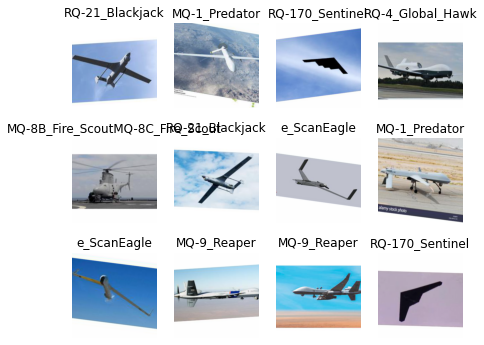

In [8]:

def label_func(x): return x.parent.name


dls = ImageDataLoaders.from_path_func(path_img, fnames, label_func,
                                      item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=bs//2,
                                     batch_tfms=[*aug_transforms(size=299, max_warp=0), Normalize.from_stats(*imagenet_stats)])
# , item_tfms=Resize(460), bs=bs, batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
dls.show_batch(max_n=12, figsize=(7,6))

In [9]:
print(dls.vocab)
len(dls.vocab),dls.c

(#14) ['MQ-19_Aerosonde','MQ-1C_Gray_Eagle','MQ-1_Predator','MQ-8B_Fire_ScoutMQ-8C_Fire_Scout','MQ-9_Reaper','RQ-11_Raven','RQ-12_Wasp','RQ-170_Sentinel','RQ-20_Puma','RQ-21_Blackjack'...]


(14, 14)


## Images 

The images for the project are held in Google Drive and can be mounted below.

In [10]:
path_img = path/'dataset'
fnames = get_image_files(path_img)
fnames

(#247) [Path('dataset/RQ-11_Raven/000048.jpg'),Path('dataset/RQ-11_Raven/000011.jpg'),Path('dataset/RQ-11_Raven/000005.jpg'),Path('dataset/RQ-11_Raven/000030.jpg'),Path('dataset/RQ-11_Raven/000001.jpg'),Path('dataset/RQ-11_Raven/000009.jpg'),Path('dataset/RQ-11_Raven/000003.jpg'),Path('dataset/MQ-1C_Gray_Eagle/000067.jpg'),Path('dataset/MQ-1C_Gray_Eagle/000066.jpg'),Path('dataset/MQ-1C_Gray_Eagle/000079.jpg')...]

Train that model. 

In [11]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fit_one_cycle(10)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,3.965060,2.837071,0.918367,00:06
1,4.004801,2.187369,0.693878,00:02
2,3.453295,2.034053,0.571429,00:02
3,2.782675,2.037796,0.571429,00:02
4,2.310455,2.059425,0.591837,00:02
5,1.971642,2.063262,0.591837,00:02
6,1.705526,2.065350,0.571429,00:02
7,1.467603,2.107294,0.571429,00:02
8,1.275360,2.089164,0.551020,00:02
9,1.149766,2.081520,0.530612,00:02


In [12]:
learn.save('stage-1')

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

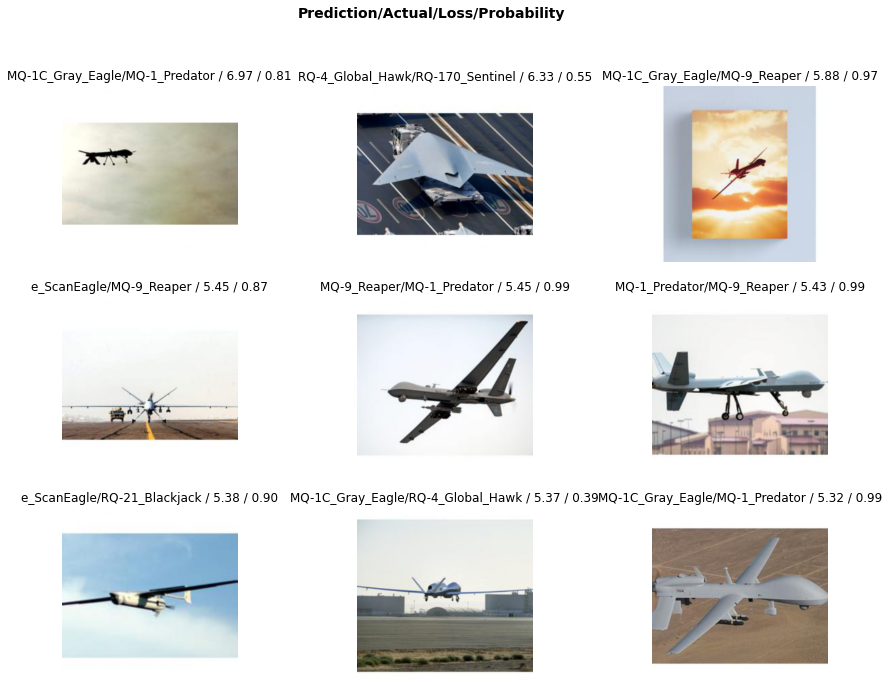

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

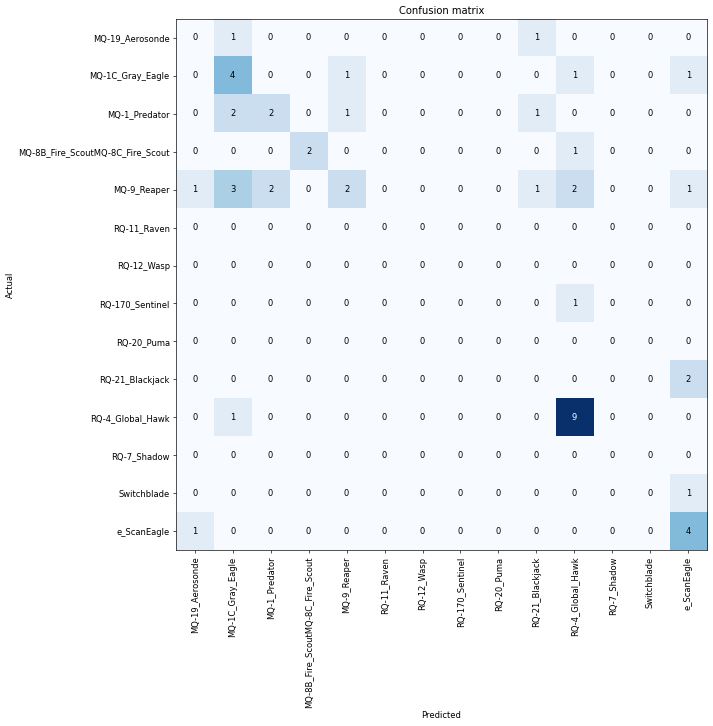

In [15]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

And everything appears confused for now:

In [16]:
interp.most_confused(min_val=2)

[('MQ-9_Reaper', 'MQ-1C_Gray_Eagle', 3),
 ('MQ-1_Predator', 'MQ-1C_Gray_Eagle', 2),
 ('MQ-9_Reaper', 'MQ-1_Predator', 2),
 ('MQ-9_Reaper', 'RQ-4_Global_Hawk', 2),
 ('RQ-21_Blackjack', 'e_ScanEagle', 2)]